In [1]:
# Import necessary libraries
import numpy as np  # Used for numerical operations and array handling
import matplotlib.pyplot as plt  # Used for plotting graphs
import itertools


try:
    import yfinance as yf
except ImportError:
    !pip install yfinance==0.2.50
    import yfinance as yf

import os
import json
import pandas as pd
from google.colab import drive
import time as T
from tqdm import tqdm  # Import tqdm for progress bar
import random
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from datetime import datetime, timedelta
from tabulate import tabulate


import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

drive.mount('/content/drive')
data_folder = '/content/drive/MyDrive/CMU Study/Stock Portfolio Maker'

Mounted at /content/drive


In [2]:
# Function to fetch top-performing companies for each sector and store them in a dictionary
def get_top_companies_by_sector():
    # List of sectors
    sectors = [
        "basic-materials",
        "communication-services",
        "consumer-cyclical",
        "consumer-defensive",
        "energy",
        "financial-services",
        "healthcare",
        "industrials",
        "real-estate",
        "technology",
        "utilities"
    ]

    sector_companies = {}

    for sector_key in sectors:
        #print(f"Fetching top companies for sector: {sector_key}")

        # Create the sector object
        sector = yf.Sector(sector_key)

        # Get the top-performing companies in the sector
        top_companies = sector.top_companies

        if top_companies is not None:
            top_companies.reset_index(drop=False, inplace=True)
            # Store the symbols of the companies in the dictionary
            sector_companies[sector_key] = top_companies['symbol'].tolist()
        else:
            pass
            #print(f"No data available for top-performing companies in the {sector_key} sector.")

    return sector_companies

In [3]:
def plot_data(data, title="Stock Prices Over Time"):
    """
    Plots the stock price data.

    Parameters:
    - data (pd.DataFrame): DataFrame of stock prices.
    - title (str): Title of the plot.
    """
    data.plot(figsize=(12, 6), linewidth=1.5)
    plt.title(title, fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Price", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [4]:
def calculate_log_returns(data):
    """
    Calculates the logarithmic returns of the stock prices.

    Parameters:
    - data (pd.DataFrame): DataFrame of stock prices.

    Returns:
    - pd.DataFrame: DataFrame of logarithmic returns.
    """
    log_returns = np.log(data / data.shift(1))
    return log_returns[1:]  # Remove the first row of NaN values

In [5]:
def display_statistics(returns):
    """
    Displays annualized statistics for stock returns.

    Parameters:
    - returns (pd.DataFrame): DataFrame of daily returns.
    """
    annual_mean = returns.mean() * NUM_TRADING_DAYS
    annual_covariance = returns.cov() * NUM_TRADING_DAYS

    # print("\nAnnualized Mean Returns:")
    # print(annual_mean)

    # print("\nAnnualized Covariance Matrix:")
    # print(annual_covariance)

In [6]:
def calculate_portfolio_metrics(returns, weights):
    """
    Calculates and displays portfolio return and volatility.

    Parameters:
    - returns (pd.DataFrame): DataFrame of daily returns.
    - weights (np.array): Array of portfolio weights.

    Returns:
    - tuple: (portfolio_return, portfolio_volatility)
    """
    annual_mean = returns.mean() * NUM_TRADING_DAYS
    annual_covariance = returns.cov() * NUM_TRADING_DAYS

    portfolio_return = np.sum(annual_mean * weights)
    portfolio_volatility = np.sqrt(
        np.dot(weights.T, np.dot(annual_covariance, weights))
    )

    print("\nPortfolio Metrics:")
    print(f"Expected Annual Return: {portfolio_return:.2%}")
    print(f"Expected Annual Volatility: {portfolio_volatility:.2%}")

    return portfolio_return, portfolio_volatility

In [7]:
def generate_portfolios(returns, num_portfolios=100000):
    """
    Generates a set of random portfolios and calculates their metrics.

    Parameters:
    - returns (pd.DataFrame): DataFrame of daily stock returns.
    - num_portfolios (int): Number of portfolios to generate.

    Returns:
    - tuple: (weights, means, risks)
        - weights (np.array): Array of portfolio weights for each portfolio.
        - means (np.array): Array of expected annual returns for each portfolio.
        - risks (np.array): Array of expected annual volatilities for each portfolio.
    """
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

    for _ in range(num_portfolios):
        # Randomly generate weights and normalize them
        weights = np.random.random(len(returns.columns))
        weights /= np.sum(weights)  # Ensure weights sum to 1

        # Store weights
        portfolio_weights.append(weights)

        # Calculate annualized return
        mean_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
        portfolio_means.append(mean_return)

        # Calculate annualized volatility
        covariance_matrix = returns.cov() * NUM_TRADING_DAYS
        risk = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
        portfolio_risks.append(risk)

    return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)

In [8]:
def calculate_statistics(weights, returns, risk_free_rate=0.06):
    """
    Calculates portfolio statistics: expected return, volatility, and Sharpe ratio.

    Parameters:
    - weights (np.array): Portfolio weights.
    - returns (pd.DataFrame): DataFrame of daily stock returns.

    Returns:
    - np.array: [expected_return, volatility, sharpe_ratio]
    """
    # Annualized return
    expected_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS

    # Annualized volatility
    volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))

    # Sharpe ratio
    sharpe_ratio = (expected_return - risk_free_rate)/ volatility

    return np.array([expected_return, volatility, sharpe_ratio])

In [9]:
def min_function_sharpe(weights, returns):
    """
    Objective function to minimize (negative Sharpe ratio).

    Parameters:
    - weights (np.array): Portfolio weights.
    - returns (pd.DataFrame): DataFrame of daily stock returns.

    Returns:
    - float: Negative Sharpe ratio.
    """
    return -calculate_statistics(weights, returns)[2]

In [10]:
def optimize_portfolio(initial_weights, returns):
    """
    Optimizes portfolio weights to maximize the Sharpe ratio.

    Parameters:
    - initial_weights (np.array): Initial guess for weights.
    - returns (pd.DataFrame): DataFrame of daily stock returns.

    Returns:
    - dict: Result of the optimization.
    """
    # Constraints: Sum of weights must equal 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    # Bounds: Weights must be between 0 and 1
    bounds = tuple((0, 1) for _ in range(len(initial_weights[0])))

    # Run the optimization
    result = minimize(fun=min_function_sharpe, x0=initial_weights[0], args=(returns,), method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [11]:
def display_optimal_portfolio(optimum, returns, stock_symbols):
    """
    Prints the optimal portfolio weights and corresponding statistics for stocks with weight > 0.

    Parameters:
    - optimum (dict): Result from the optimization.
    - returns (pd.DataFrame): DataFrame of daily stock returns.
    - stock_symbols (list): List of stock symbols corresponding to the weights.
    """
    # Extract optimal weights and calculate statistics
    optimal_weights = optimum['x'].round(3)
    stats = calculate_statistics(optimal_weights, returns)

    # Filter weights > 0 and corresponding stock symbols
    significant_weights = {symbol : weight for symbol, weight in zip(stock_symbols, optimal_weights) if weight > 0}

    # Display the portfolio details
    # print("\nOptimal Portfolio Weights (for weights > 0):")
    # for symbol, weight in significant_weights.items():
    #     print(f"{symbol}: {weight:.3f}")

    # print("\nPortfolio Statistics:")
    # print(f"Expected Return: {stats[0]:.3f}")
    # print(f"Expected Volatility: {stats[1]:.3f}")
    # print(f"Sharpe Ratio: {stats[2]:.3f}")

    return {"Return" : round(stats[0], 4), "Volatility": round(stats[1], 4), "Sharpe Ratio": round(stats[2], 4), "Portfolio" : significant_weights}

In [12]:
def plot_optimal_portfolio(optimum, returns, portfolio_means, portfolio_vols):
    """
    Plots the efficient frontier and highlights the optimal portfolio.

    Parameters:
    - optimum (dict): Result from the optimization.
    - returns (pd.DataFrame): DataFrame of daily stock returns.
    - portfolio_means (np.array): Array of portfolio expected returns.
    - portfolio_vols (np.array): Array of portfolio volatilities.
    """
    plt.figure(figsize=(10, 6))

    # Scatter plot of portfolios
    plt.scatter(portfolio_vols, portfolio_means, c=portfolio_means / portfolio_vols, marker='o')
    plt.colorbar(label='Sharpe Ratio')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')

    # Highlight the optimal portfolio
    opt_stats = calculate_statistics(optimum['x'], returns)
    plt.plot(opt_stats[1], opt_stats[0], 'g*', markersize=20.0, label='Optimal Portfolio')

    plt.legend()
    plt.title('Efficient Frontier and Optimal Portfolio')
    plt.show()

In [ ]:
# Constants
NUM_TRADING_DAYS = 252  # Average trading days in a year
NUM_PORTFOLIOS = 1000  # Number of portfolios to generate

# List of stock tickers
stocks = ['AAPL', 'MSFT', 'XYZ', 'NFLX']
#stocks = sector_companies_dict['communication-services']

# Fetch historical data for these stocks (e.g., 1 year of daily data)
data = yf.download(stocks, start="2024-01-02", end="2025-03-06", auto_adjust=False)['Adj Close']

# Plot the stock prices
#plot_data(data)

# Step 2: Calculate Log Daily Returns and Display Statistics
log_daily_returns = calculate_log_returns(data)
display_statistics(log_daily_returns)

# Step 3: Generate Portfolios
pweights, means, risks = generate_portfolios(log_daily_returns, NUM_PORTFOLIOS)

# Step 4: Optimize Portfolio
optimum = optimize_portfolio(pweights, log_daily_returns)


# Display optimal portfolio weights and statistics
x = display_optimal_portfolio(optimum, log_daily_returns, stocks)

# Step 5: Plot Efficient Frontier and Optimal Portfolio
#plot_optimal_portfolio(optimum, log_daily_returns, means, risks)

[*********************100%***********************]  4 of 4 completed


In [13]:
def portfolio_performance(stocks, portfolio_weights, start_date, end_date, today_date, initial_investment):
    # Get stock symbols
    symbols = list(portfolio_weights.keys())

    # Fetch historical prices individually
    last_prices = {}
    current_prices = {}
    delisted_stocks = []

    # Dictionary to store daily portfolio values
    portfolio_values = []

    # Fetch historical price for each stock
    historical_data = stocks['Adj Close'].loc[:, symbols]

    historical_data.reset_index(drop=False, inplace=True)

    # Filter the data to get the date range from 'end_date' to 'today_date'
    date_range = historical_data[(historical_data['Date'] >= pd.to_datetime(end_date)) & (historical_data['Date'] <= pd.to_datetime(today_date))]['Date']

    for symbol in symbols:
        try:
            # Dropping na
            historical_data.dropna(inplace=True)
            last_prices[symbol] = historical_data[historical_data['Date'] == end_date][symbol].iloc[0]  # Last available price
        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}")
            delisted_stocks.append(symbol)
    # Calculate number of shares purchased per stock
    shares_purchased = {symbol: (initial_investment * weights) / last_prices[symbol] for symbol, weights in portfolio_weights.items()}


    for date in date_range:
        daily_total_value = 0

        for symbol in symbols:
            try:
                # Calculate the new value of each stock holding
                current_prices[symbol] = historical_data[historical_data['Date'] == date][symbol].iloc[0]
            except:
                current_prices[symbol] = 0

            daily_total_value += shares_purchased[symbol] * current_prices[symbol]

        # Append the daily total portfolio value
        portfolio_values.append(daily_total_value)

    # Convert portfolio values to a pandas series
    portfolio_values_series = pd.Series(portfolio_values, index=date_range)


    # Calculate daily returns
    daily_returns = portfolio_values_series.pct_change().dropna() * 100  # Percentage change

    # Plot portfolio value over time
    plt.figure(figsize=(10, 4))
    plt.plot(portfolio_values_series, label="Portfolio Value", color='blue')
    plt.title("Portfolio Value Over Time")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value ($)")
    plt.grid(True)
    plt.legend(loc='upper left')

    # Show the plots
    plt.show()

In [14]:
def filter_low_sharpe_stocks(stocks, sharpe_threshold=0.5, risk_free_rate=0.02, num_trading_days=252):
    """
    Filters stocks based on their Sharpe ratio, retaining stocks with a Sharpe ratio greater than the threshold.

    Parameters:
    - stocks (pd.DataFrame): The stock data.
    - sharpe_threshold (float): The minimum Sharpe ratio for filtering.
    - risk_free_rate (float): The annual risk-free rate (default 2%).
    - num_trading_days (int): The number of trading days in a year (default 252).

    Returns:
    - pd.DataFrame: The filtered stock data.
    """
    symbols = []  # List to store selected symbols
    temp_data = stocks['Adj Close']  # Using adjusted close prices

    # Loop through each stock column (i.e., each symbol)
    for column in temp_data.columns:
        log_returns = np.log(temp_data[column] / temp_data[column].shift(1))[1:]

        # Calculate annualized return (mean log return * number of trading days)
        expected_return = float(log_returns.mean() * num_trading_days)

        # Calculate annualized volatility (sqrt of variance * number of trading days)
        volatility = float(np.sqrt(log_returns.var() * num_trading_days))

        # Calculate Sharpe ratio
        sharpe_ratio = (expected_return - risk_free_rate) / volatility

        # Filter stocks based on Sharpe ratio threshold
        if sharpe_ratio > sharpe_threshold:
            symbols.append(column)

    # Apply filtering correctly on MultiIndex columns
    stocks = stocks.loc[:, (slice(None), list(symbols))]

    return stocks

In [15]:
def filter_liquid_stocks(stocks, start_date, end_date, min_volume=1_000_000):
    """
    Filters stocks based on their average volume over a given date range.

    Parameters:
    - symbols (list): A list of stock ticker symbols.
    - start_date (str): The start date to fetch historical data (YYYY-MM-DD).
    - end_date (str): The end date to fetch historical data (YYYY-MM-DD).
    - min_volume (int, optional): The minimum average daily trading volume required
      for a stock to be considered liquid. Default is 1,000,000.

    Returns:
    - list: A list of ticker symbols that meet the liquidity requirement.
    """
    # Fetch historical volume data for the given symbols over the date range
    historical_data = stocks['Volume']

    # Calculate the average volume for each symbol (stock)
    avg_volumes = historical_data.mean()

    # Filter out the symbols that meet the minimum volume threshold
    liquid_stocks = avg_volumes[avg_volumes >= min_volume].index.tolist()

    # Apply filtering correctly on MultiIndex columns
    stocks = stocks.loc[:, (slice(None), list(liquid_stocks))]

    return stocks

In [16]:
def filter_available_stocks(symbols, start_date, end_date, today_date):
    """
    Filters out stocks that do not have data available on all three specified dates
    and retains the filtered columns for all data points like Open, Close, Adj Close, etc.

    Parameters:
    - symbols (list): List of stock ticker symbols.
    - start_date (str): The start date (YYYY-MM-DD) to check availability.
    - end_date (str): The end date (YYYY-MM-DD) to check availability.
    - today_date (str): The most recent date to check availability.

    Returns:
    - DataFrame: Historical data with only the stocks that are available on all three dates.
    """

    # Fetch historical stock data for the given symbols
    historical_data = yf.download(symbols, start=start_date, end=today_date, auto_adjust=False)

    # Define the previous date (1 day before today_date)
    previous_date = pd.to_datetime(today_date) - pd.Timedelta(days=1)

    # Set to store the intersection of all available stocks across all data points
    all_columns = None

    # Iterate through all stock data points (Open, Close, High, Low, etc.)
    for column in historical_data.columns.levels[0]:
        temp_data = historical_data[column]  # Extract the specific data point

        # Keep only rows corresponding to the three key dates
        temp_data = temp_data.loc[[pd.to_datetime(start_date), pd.to_datetime(end_date), previous_date]]

        # Drop stocks (columns) that have missing data (NaN) for any of these dates
        temp_data.dropna(axis=1, inplace=True)

        # Store the common stock symbols that exist across all data points
        if all_columns is None:
            all_columns = set(temp_data.columns)
        else:
            all_columns = all_columns.intersection(set(temp_data.columns))

    to_return_df = pd.DataFrame(index=historical_data.index)

    # Apply filtering correctly on MultiIndex columns
    historical_data = historical_data.loc[:, (slice(None), list(all_columns))]


    return historical_data  # Return the filtered stock data

In [17]:
def filter_max_price_stocks(stocks, max_price=100):
    """
    Filters stocks based on their last available Adjusted Close price,
    retaining only those with a price below the given threshold.

    Parameters:
    - stocks (pd.DataFrame): The stock data (multi-level columns).
    - max_price (float): The maximum allowed price per share.

    Returns:
    - pd.DataFrame: The filtered stock data.
    """
    # Get the last available adjusted close prices using iloc[-1]
    last_prices = stocks['Adj Close'].iloc[-1]

    # Find stocks where the last Adjusted Close is below the threshold
    symbols = last_prices[last_prices < max_price].index.tolist()

    # Apply filtering correctly on MultiIndex columns
    stocks = stocks.loc[:, (slice(None), symbols)]

    return stocks

In [18]:
# Loop through sectors and combinations dynamically based on number of sectors to choose from
def loop_through_sectors_and_combinations(stocks, sector_companies_dict, min_num, max_num, start_date, end_date, today_date, initial_investment):
    sector_combinations = {}
    # Loop through combinations of sectors (1 to all sectors)
    for r in range(min_num, max_num + 1):
        for comb in itertools.combinations(sector_companies_dict.keys(), r):
            print("\n\n========================================================================================================================================================================")
            combo_str = " + ".join(comb)  # Create a readable combo string

            if combo_str not in sector_combinations.keys():
                sector_combinations[combo_str] = []

            # Get symbols for each sector in the combination
            all_symbols = []
            for sector in comb:
                symbols = sector_companies_dict[sector]
                if not symbols:
                    #print(f"No data for sector {sector}, skipping combination {combo_str}")
                    break
                all_symbols.extend(symbols)

            # Step 1: Fetch historical data for these stocks (e.g., 1 year of daily data)
            data = stocks['Adj Close'].loc[start_date : end_date, all_symbols]

            # Step 2: Calculate Log Daily Returns and Display Statistics
            log_daily_returns = calculate_log_returns(data)
            display_statistics(log_daily_returns)

            # Step 3: Generate Portfolios
            pweights, means, risks = generate_portfolios(log_daily_returns, NUM_PORTFOLIOS)

            # Step 4: Optimize Portfolio
            optimum = optimize_portfolio(pweights, log_daily_returns)

            # Display optimal portfolio weights and statistics
            portfolio = display_optimal_portfolio(optimum, log_daily_returns, all_symbols)
            sector_combinations[combo_str].append(portfolio)

            # Save JSON file
            file_path = os.path.join(data_folder, "portfolios.json")  # Full path for the file

            with open(file_path, "w") as json_file:
                json.dump(sector_combinations, json_file, indent=4)

            #portfolio_performance(stocks, sector_combinations[combo_str][-1]["Portfolio"], start_date, end_date, today_date, initial_investment)

    return sector_combinations

In [ ]:
# Constants
NUM_TRADING_DAYS = 252  # Average trading days in a year
NUM_PORTFOLIOS = 10000 # Number of portfolios to generate

start_date = "2024-01-02"
end_date = "2025-01-02"
today_date = "2025-03-06"

initial_investment = 100000

# Call the function and store the result in a dictionary
sector_companies_dict = get_top_companies_by_sector()

symbols = [s for stack in sector_companies_dict.values() for s in stack]

#symbols = ["AAPL", "MSFT", "XYZ"]

stocks = filter_available_stocks(symbols, start_date, end_date, today_date)

print("\n\nStocks available on all three dates:", len(stocks['Volume'].columns.tolist()))

min_volume = 1_000_000  # Minimum average daily volume for a stock to be considered liquid

# Call the function to filter the symbols based on liquidity
stocks = filter_liquid_stocks(stocks, start_date, end_date, min_volume)

print(stocks)

# Print the list of liquid stocks
print("\nNumber of liquid stocks:", len(stocks['Volume'].columns.tolist()))

stocks = filter_low_sharpe_stocks(stocks, sharpe_threshold=0.5, risk_free_rate=0.06)

# Print the list of stocks with good sharpe ratios
print("\nNumber of fruitful stocks:", len(stocks['Volume'].columns.tolist()))

sector_companies_dict = {key: [stock for stock in value if stock in stocks['Adj Close'].columns.tolist()] for key, value in sector_companies_dict.items()}

# Run the function and get the Sharpe ratios
sector_combinations = loop_through_sectors_and_combinations(stocks, sector_companies_dict, min_num=7, max_num=7, start_date=start_date, end_date=end_date, today_date=today_date, initial_investment=initial_investment)

[*********************100%***********************]  5 of 5 completed



Stocks available on all three dates: 5
Price        Adj Close       Close        High         Low        Open  \
Ticker             LIN         LIN         LIN         LIN         LIN   
Date                                                                     
2024-01-02  404.644684  409.579987  411.730011  406.700012  409.779999   
2024-01-03  403.785126  408.709991  409.859985  405.290009  405.899994   
2024-01-04  403.666595  408.589996  411.649994  407.579987  407.640015   
2024-01-05  404.190216  409.119995  410.489990  406.250000  409.049988   
2024-01-08  403.370209  408.290009  409.989990  404.359985  407.859985   
...                ...         ...         ...         ...         ...   
2025-02-27  460.279999  460.279999  468.230011  459.880005  463.540009   
2025-02-28  467.049988  467.049988  468.339996  460.630005  465.070007   
2025-03-03  462.250000  462.250000  472.230011  460.980011  469.100006   
2025-03-04  461.350006  461.350006  469.279999  459.880005  468.600006 

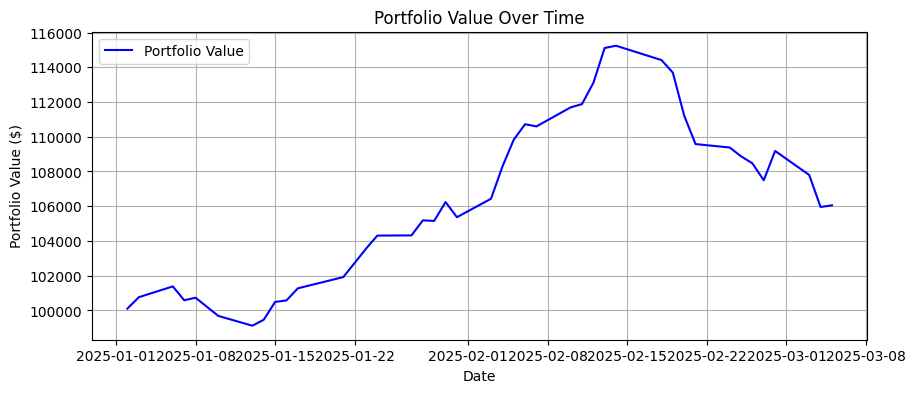

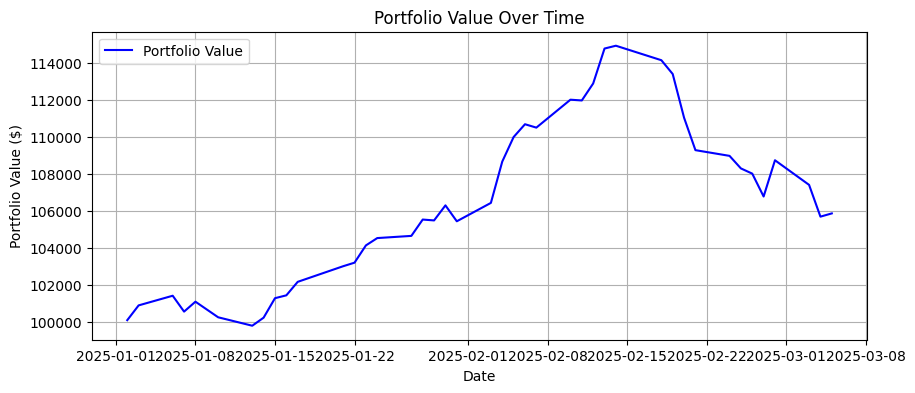

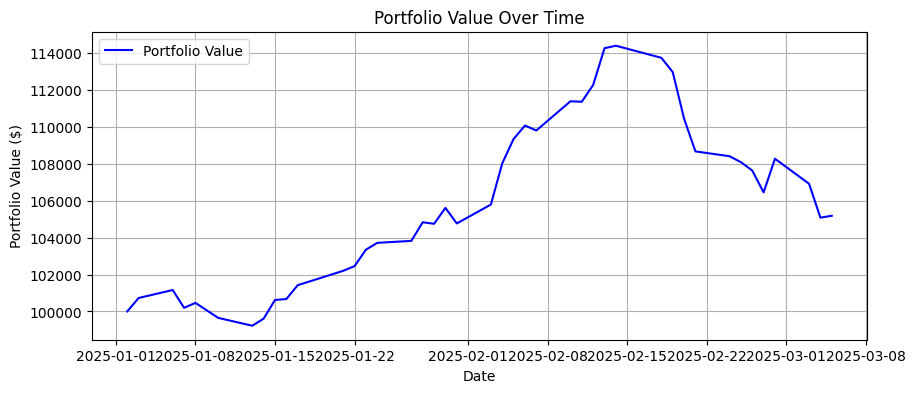

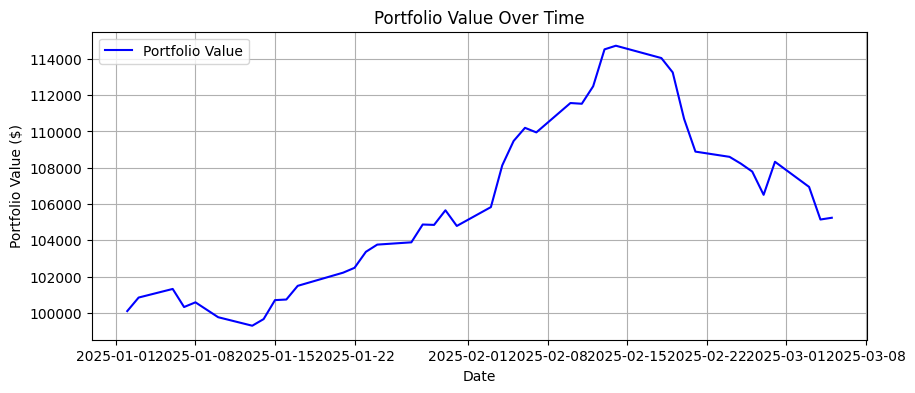

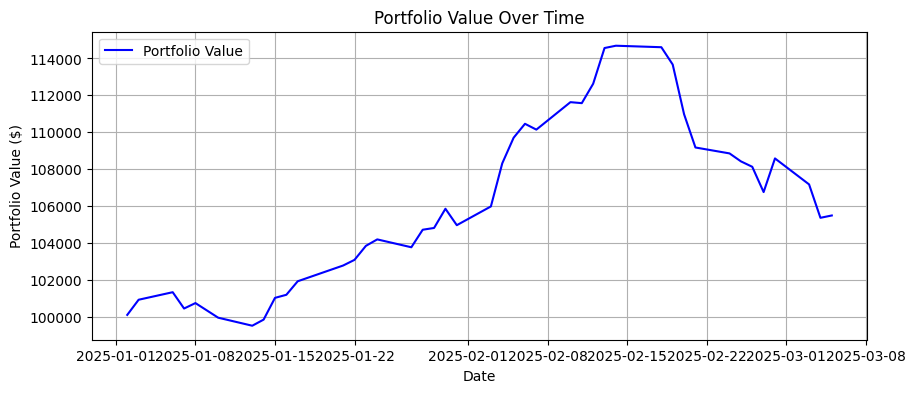

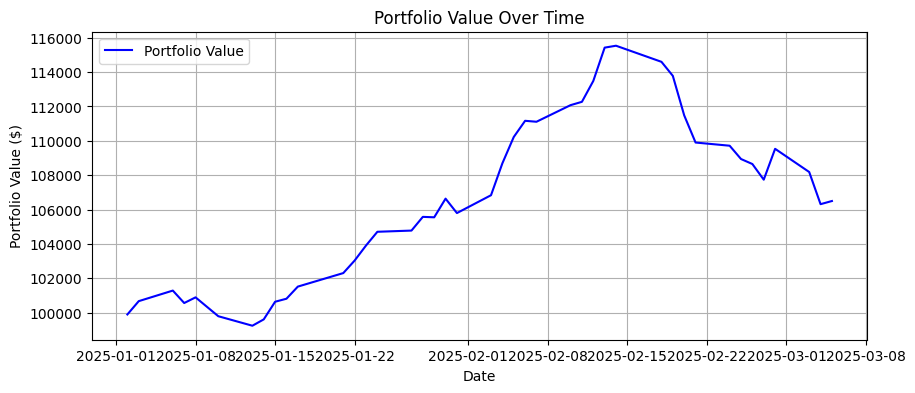

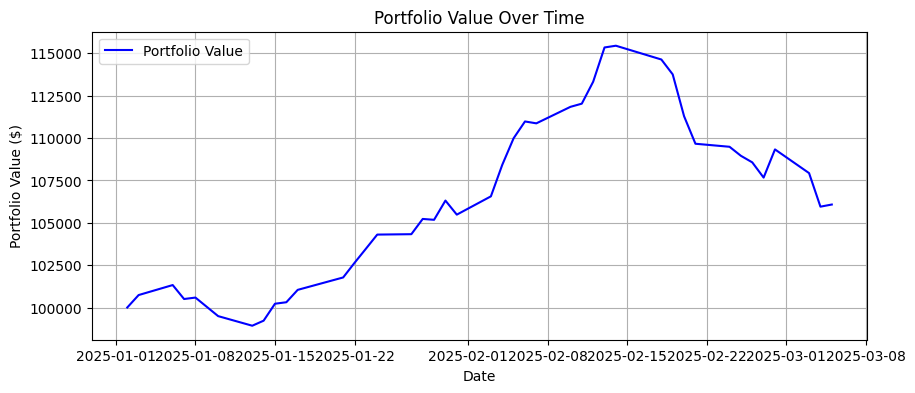

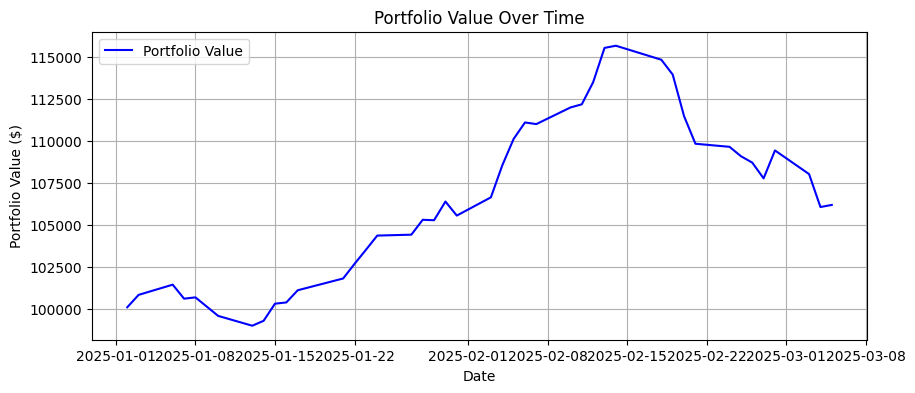

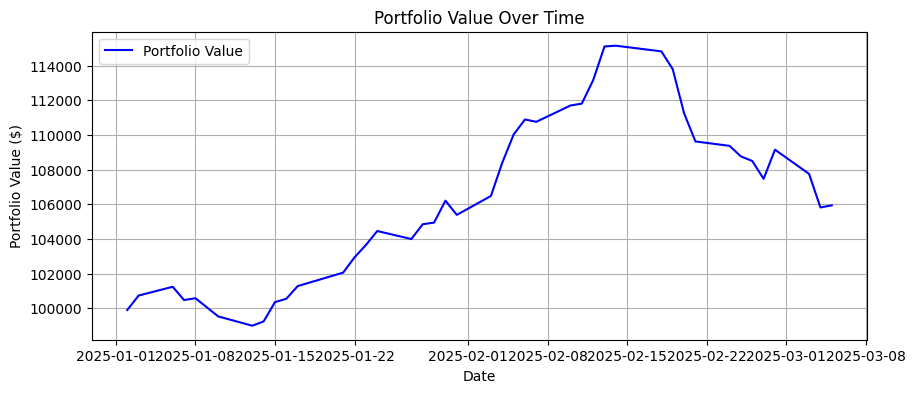

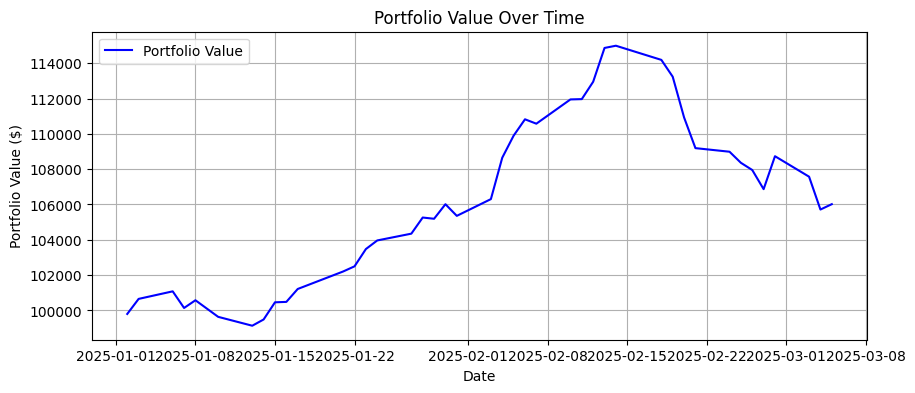

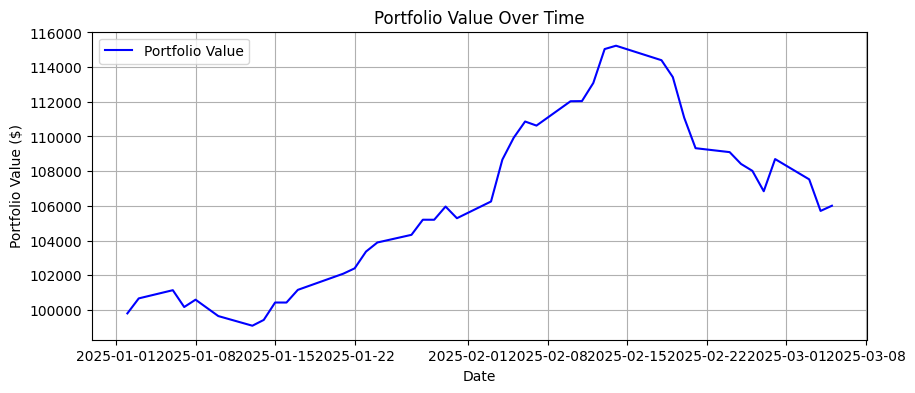

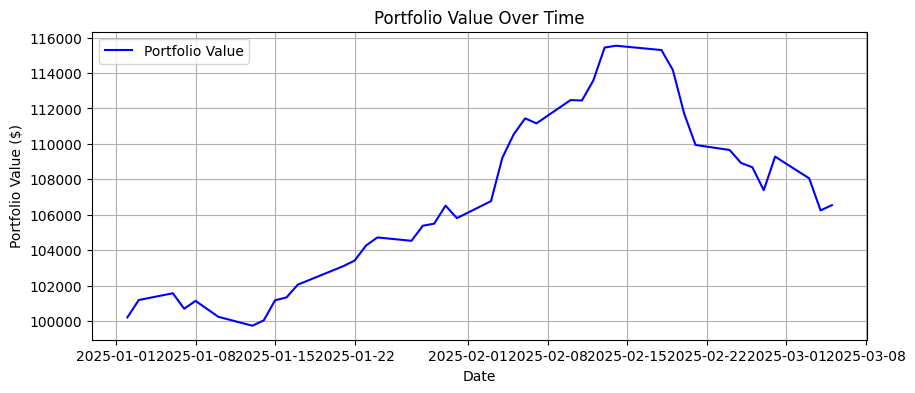

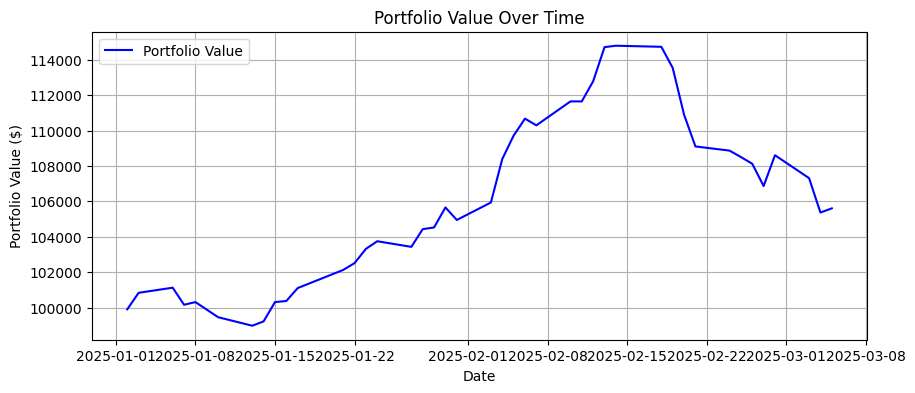

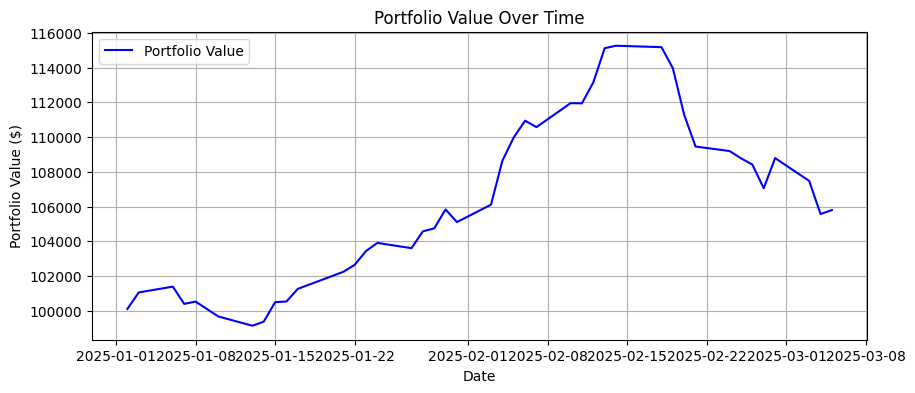

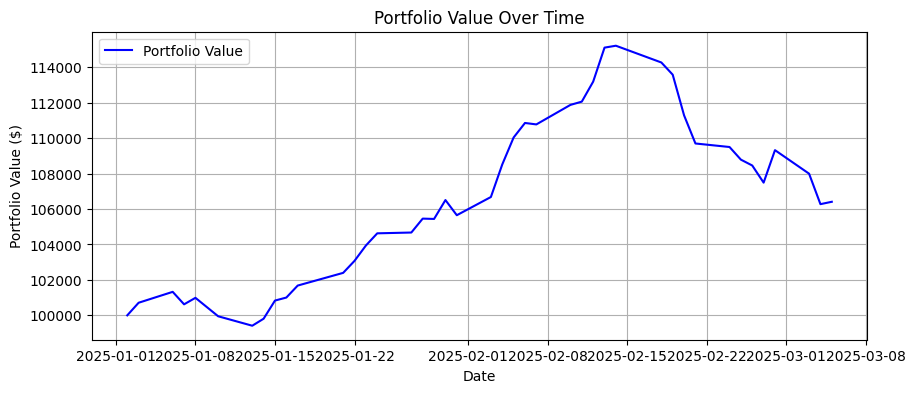

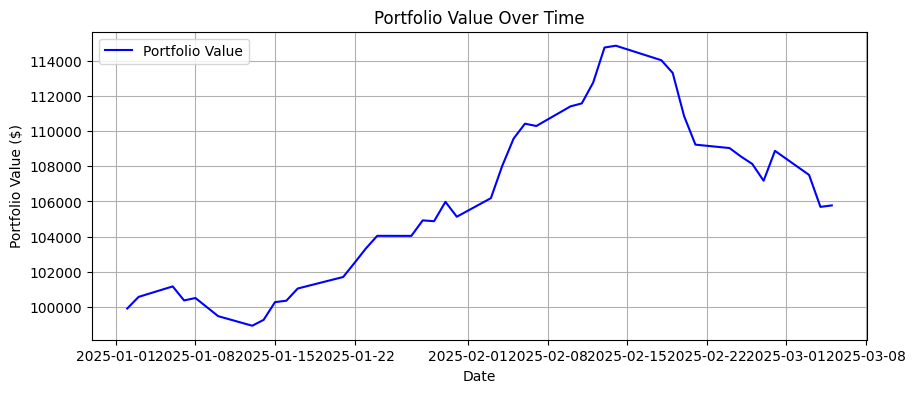

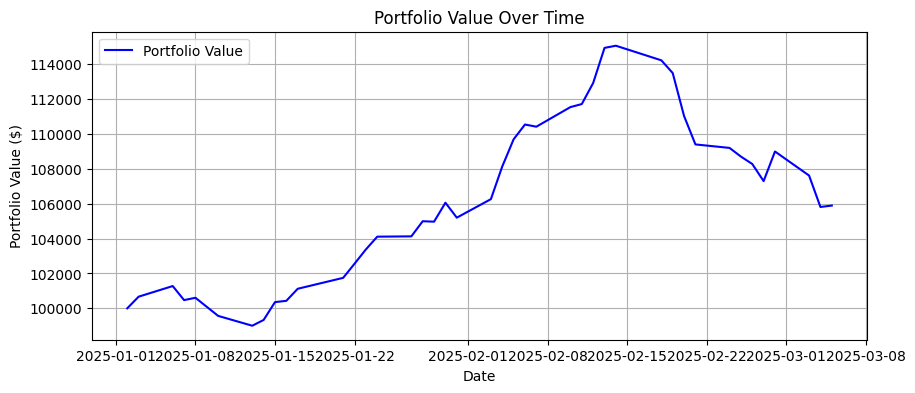

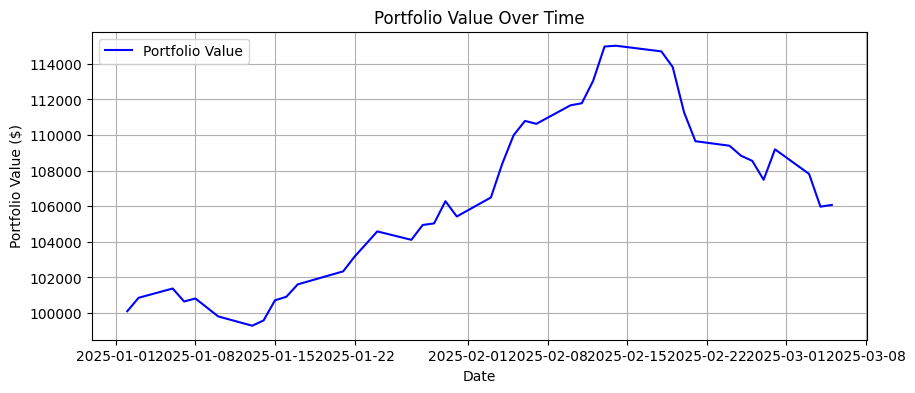

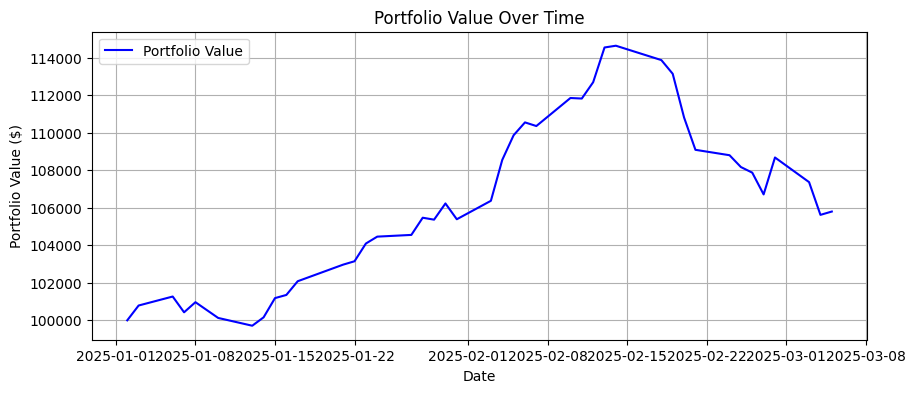

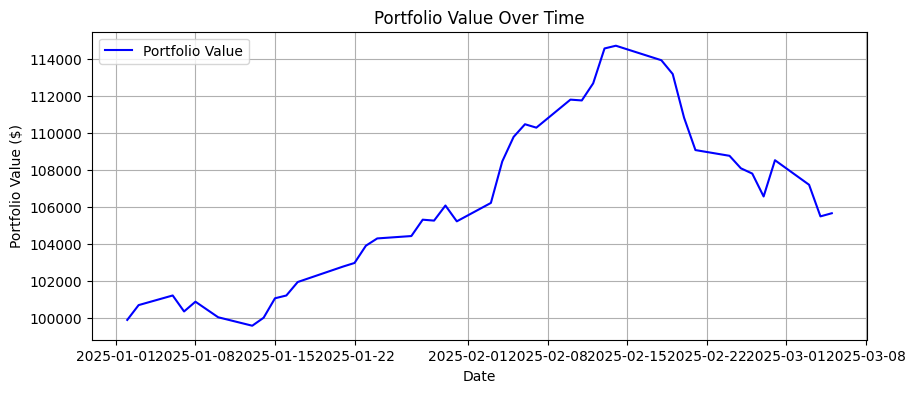

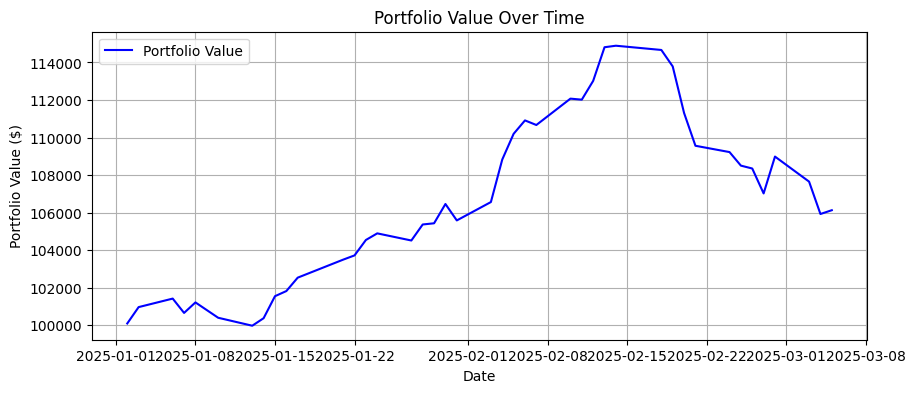

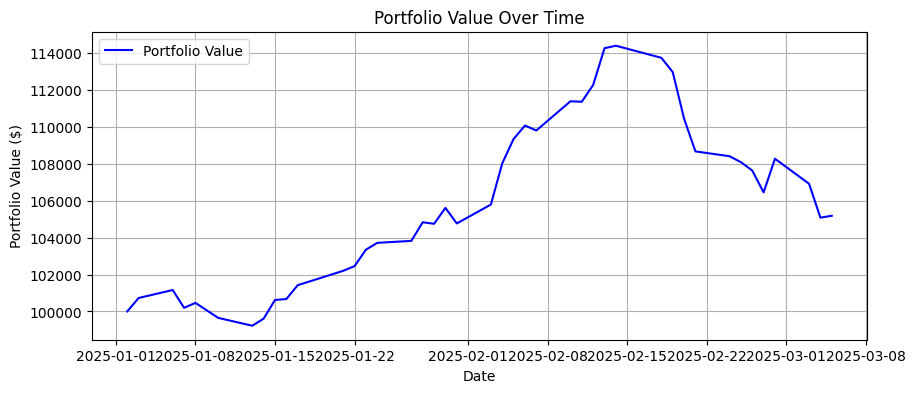

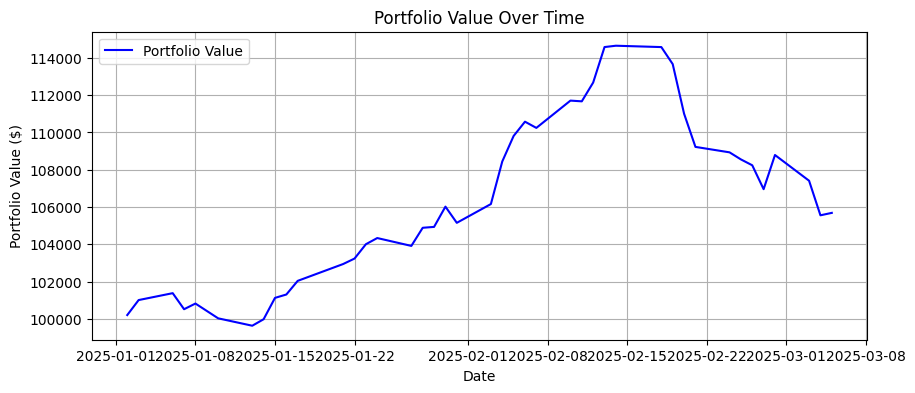

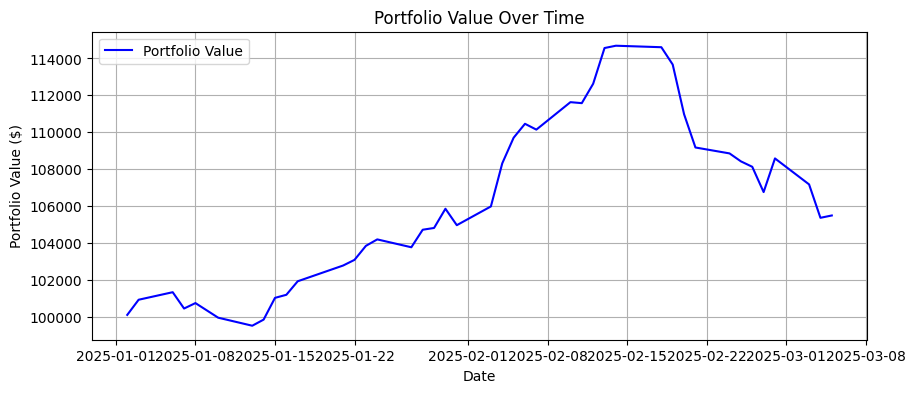

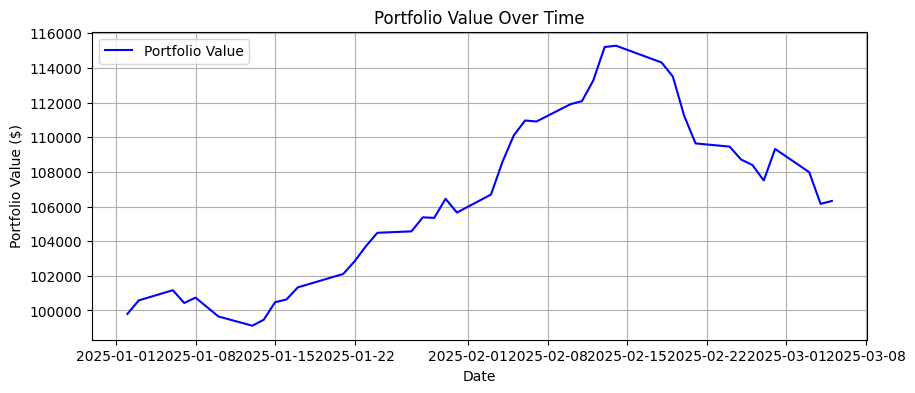

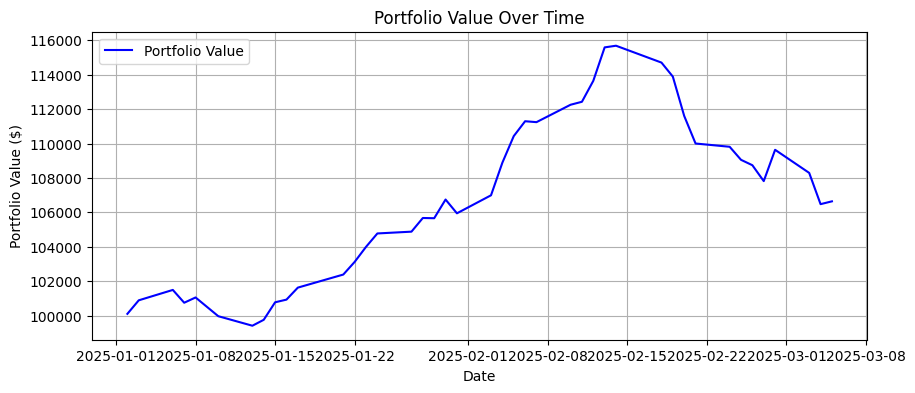

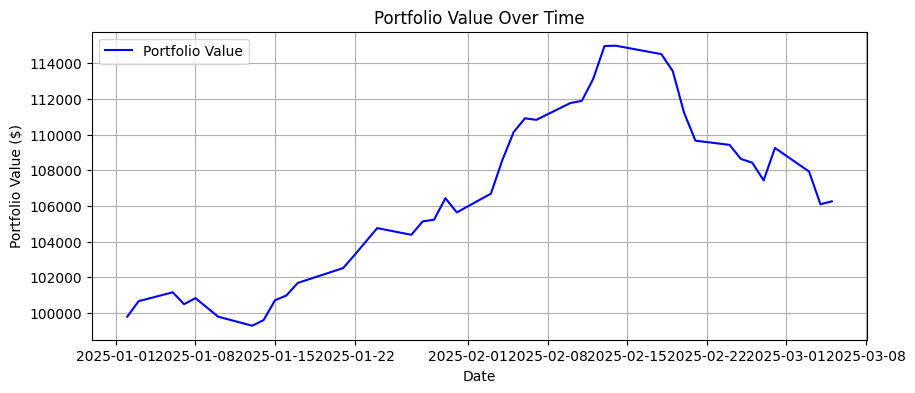

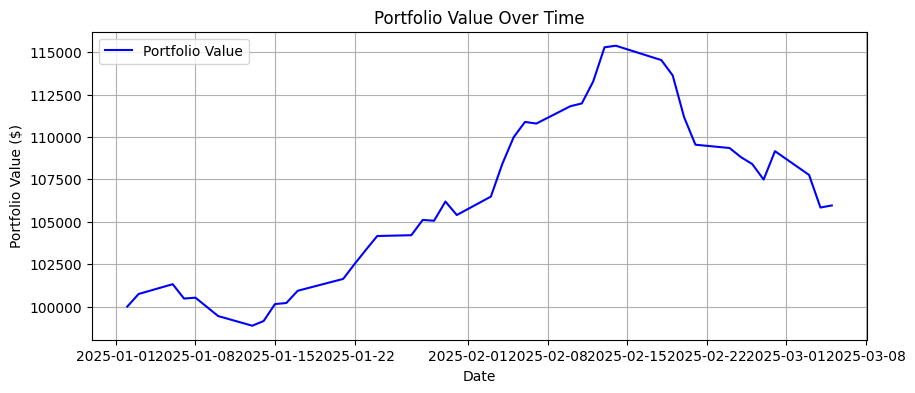

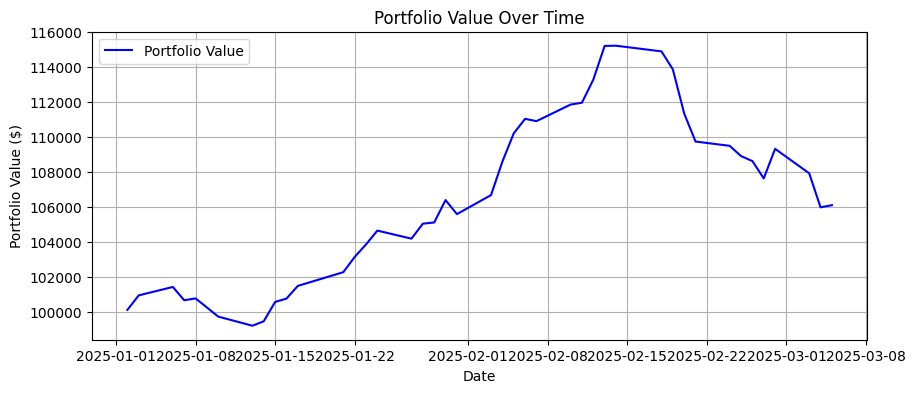

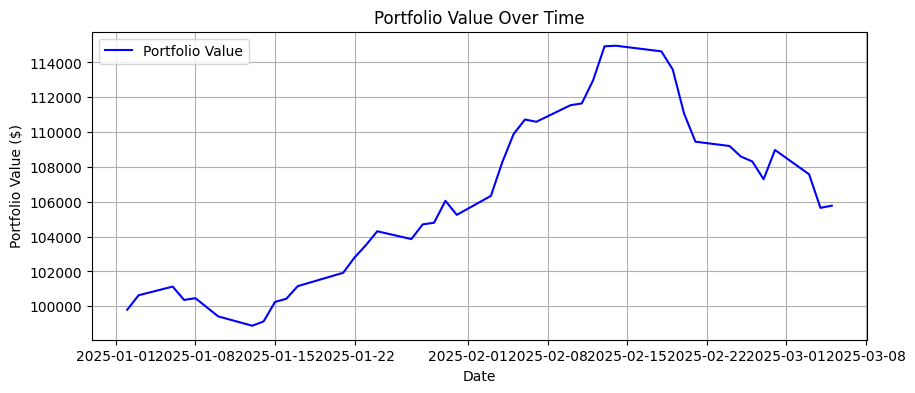

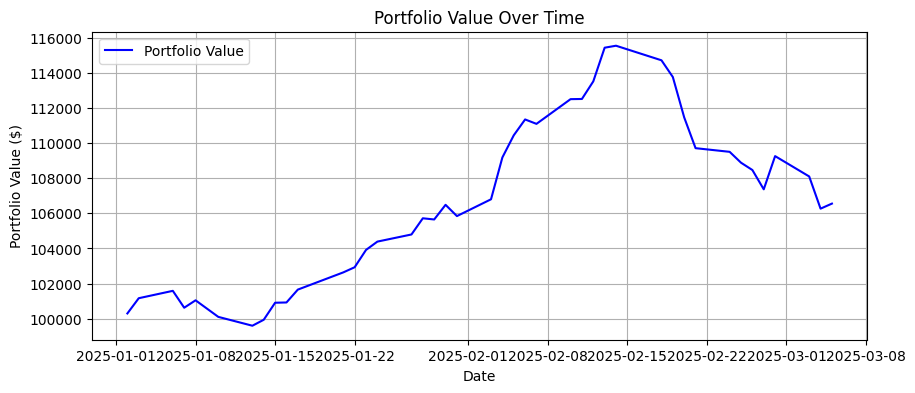

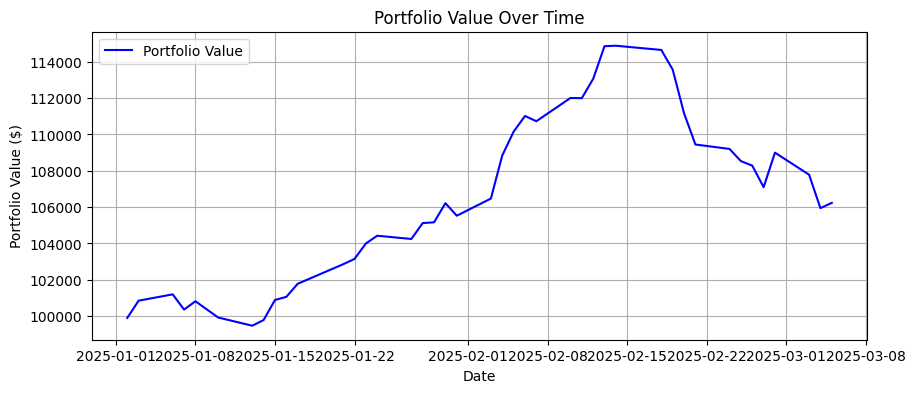

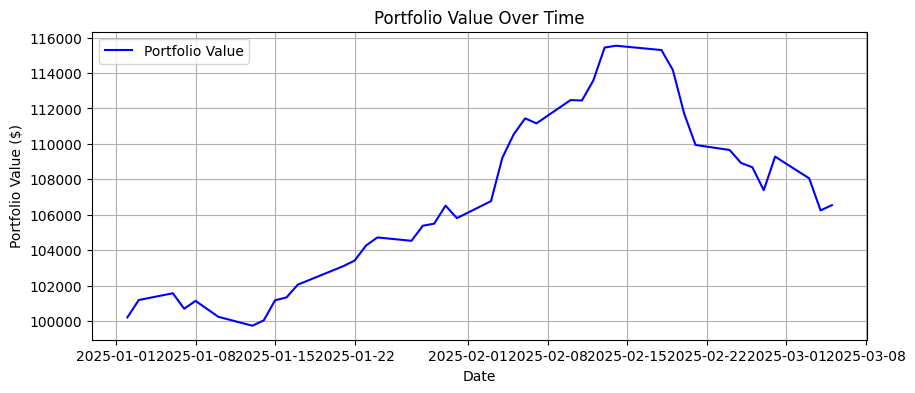

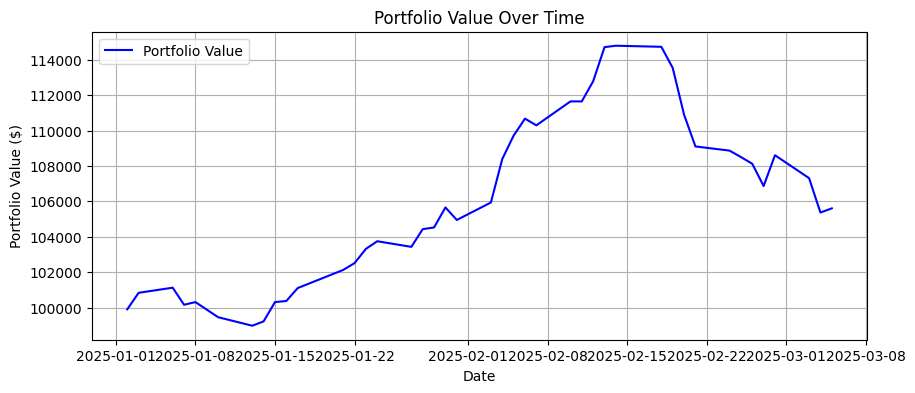

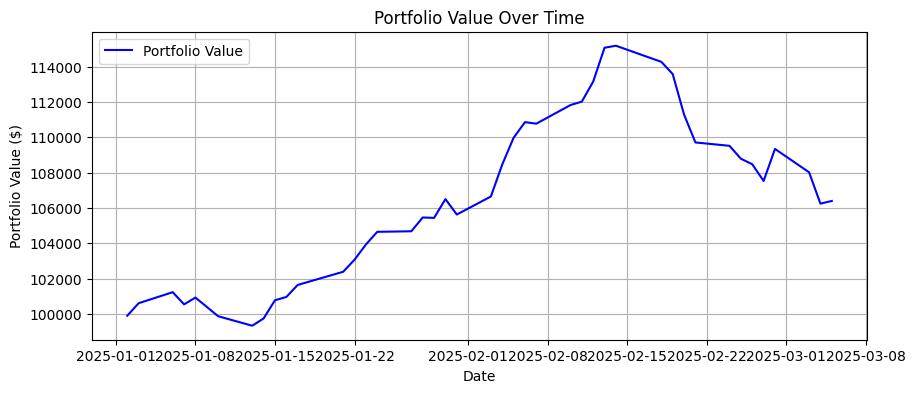

In [ ]:
# Define file path
data_folder = "/content/drive/MyDrive/CMU Study/Quant Finance"
file_path = os.path.join(data_folder, "portfolios.json")

# Load JSON data into a dictionary
with open(file_path, "r") as json_file:
    portfolios = json.load(json_file)

# Filter records where all "Sharpe Ratio" values are > 5.5
for key, portfolio in portfolios.items():
    if portfolio[0]["Sharpe Ratio"] > 5.8:
        portfolio_performance(stocks, portfolio[0]["Portfolio"], start_date, end_date, today_date, initial_investment)

In [19]:
# URL for S&P 500 Wikipedia table
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

# Read tables from Wikipedia
tables = pd.read_html(url)

# S&P 500 table is usually the first table
sp500_df = tables[0]

# Extract ticker symbols
sp500_symbols = sp500_df["Symbol"].tolist()

# Constants
NUM_TRADING_DAYS = 252  # Average trading days in a year
NUM_PORTFOLIOS = 1000 # Number of portfolios to generate

start_date = "2025-01-02"
end_date = "2025-03-12"
today_date = "2025-03-18"

initial_investment = 100000

symbols = sp500_symbols.copy()
#symbols = ["AAPL", "MSFT", "XYZ"]

stocks = filter_available_stocks(symbols, start_date, end_date, today_date)

print("\n\nStocks available on all three dates:", len(stocks['Volume'].columns.tolist()))

min_volume = 1_000_000  # Minimum average daily volume for a stock to be considered liquid

# Call the function to filter the symbols based on liquidity
stocks = filter_liquid_stocks(stocks, start_date, end_date, min_volume)

# Print the list of liquid stocks
print("\nNumber of liquid stocks:", len(stocks['Volume'].columns.tolist()))

stocks = filter_max_price_stocks(stocks, max_price=50)

#stocks = filter_low_sharpe_stocks(stocks, sharpe_threshold=-2, risk_free_rate=0.06)

#print(stocks)

# Print the list of stocks with good sharpe ratios
print("\nNumber of fruitful stocks:", len(stocks['Volume'].columns.tolist()))

[*********************100%***********************]  503 of 503 completed
ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-01-02 -> 2025-03-18)')




Stocks available on all three dates: 501

Number of liquid stocks: 412

Number of fruitful stocks: 82


In [25]:
stock_list = stocks['Volume'].columns.tolist()  # Get list of all stocks
for stock in stock_list:
    print(stock, stocks['Adj Close'][stock].iloc[-1])

IPG 26.229999542236328
PCG 17.110000610351562
FE 39.83000183105469
NEM 47.52000045776367
F 9.920000076293945
PFE 26.049999237060547
GEN 27.850000381469727
APA 20.030000686645508
KHC 30.65999984741211
MGM 32.41999816894531
KEY 15.800000190734863
BAC 41.439998626708984
HRL 29.959999084472656
WDC 44.75
CTRA 28.15999984741211
T 26.829999923706055
HBAN 14.744999885559082
GM 49.0
FCX 39.5099983215332
BKR 43.880001068115234
RF 21.540000915527344
UDR 43.880001068115234
ON 44.04999923706055
LVS 43.66999816894531
DAL 46.88999938964844
MTCH 31.360000610351562
GLW 46.86000061035156
VICI 32.4900016784668
CSX 30.329999923706055
ADM 47.9900016784668
CNP 35.59000015258789
CAG 26.06999969482422
CCL 20.889999389648438
DOW 37.5099983215332
BAX 34.849998474121094
KIM 20.739999771118164
WBA 11.260000228881836
TFC 41.04999923706055
KDP 33.84000015258789
VZ 43.650001525878906
HPE 15.84000015258789
INVH 33.810001373291016
HPQ 28.90999984741211
NCLH 20.040000915527344
DOC 20.510000228881836
HAL 25.219999313354

In [ ]:
best_portfolio = None  # Store the best portfolio
best_sharpe = float('-inf')  # Initialize with negative infinity

stock_list = stocks['Volume'].columns.tolist()  # Get list of all stocks
max_ = min(6, len(stock_list))  # Set limit for subset size (adjust as needed)
min_ = 6 #limit to start combination from

# Loop through subset sizes from 1 to n
for subset_size in range(min_, max_ + 1):
    for subset in itertools.combinations(stock_list, subset_size):  # Generate all combinations
        subset = list(subset)
        # Step 1: Fetch data for the selected subset
        data = stocks['Adj Close'].loc[start_date : end_date, subset]

        # Step 2: Calculate Log Daily Returns
        log_daily_returns = calculate_log_returns(data)

        # Step 3: Generate Portfolios
        pweights, means, risks = generate_portfolios(log_daily_returns, NUM_PORTFOLIOS)

        # Step 4: Optimize Portfolio
        optimum = optimize_portfolio(pweights, log_daily_returns)

        # Display optimal portfolio weights and statistics
        portfolio = display_optimal_portfolio(optimum, log_daily_returns, subset)

        # Extract the Sharpe Ratio
        sharpe_ratio = portfolio['Sharpe Ratio']

        # Step 5: Update the best portfolio if Sharpe Ratio is higher
        if sharpe_ratio > best_sharpe:
            best_sharpe = sharpe_ratio
            best_portfolio = portfolio  # Store the best portfolio

In [ ]:
print("\nPortfolio Statistics:")
print(f"Expected Return: {best_portfolio['Return']:.3f}")
print(f"Expected Volatility: {best_portfolio['Volatility']:.3f}")
print(f"Sharpe Ratio: {best_portfolio['Sharpe Ratio']:.3f}")

In [ ]:
# Investment amount
total_investment = 100000

# Portfolio weights
portfolio = best_portfolio["Portfolio"]

# Fetch stock prices
symbols = list(portfolio.keys())
prices = yf.download(symbols, period="1d", auto_adjust=False)["Adj Close"].iloc[-1]  # Latest prices

# Prepare table data
data = []
for symbol, weight in portfolio.items():
    money_invested = total_investment * weight
    stock_price = prices[symbol] if symbol in prices else 0
    shares_to_buy = money_invested / stock_price if stock_price > 0 else 0

    data.append([symbol, weight, round(money_invested, 2), round(stock_price, 2), round(shares_to_buy, 2)])

# Convert to DataFrame
df = pd.DataFrame(data, columns=["Stock Symbol", "Weightage", "Money Invested", "Stock Price", "Shares to Buy"])

# Print table using tabulate
print(tabulate(df, headers="keys", tablefmt="grid"))

In [ ]:
portfolio